In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../')
import picea
picea.__version__,picea

('0.0.14', <module 'picea' from '../picea/__init__.py'>)

In [2]:
from picea import Tree

In [3]:
tree = Tree.from_newick(filename='./data/tree.newick')
print(tree.to_json(indent=2))

{
  "ID": 0,
  "name": "",
  "length": 0.0,
  "children": [
    {
      "ID": 1,
      "name": "Eucgr.J03126.1",
      "length": 0.096360892,
      "children": []
    },
    {
      "ID": 2,
      "name": "1.000",
      "length": 0.159121648,
      "children": [
        {
          "ID": 3,
          "name": "Eucgr.F03978.1",
          "length": 0.022217443,
          "children": []
        },
        {
          "ID": 4,
          "name": "0.989",
          "length": 0.033587992,
          "children": [
            {
              "ID": 5,
              "name": "Eucgr.F03972.1",
              "length": 0.049020651,
              "children": []
            },
            {
              "ID": 6,
              "name": "0.992",
              "length": 0.028383846,
              "children": [
                {
                  "ID": 7,
                  "name": "Eucgr.F03974.1",
                  "length": 0.016885197,
                  "children": []
                },
                {

In [4]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0],
              [4, 2], [4, 4], [4, 0]])
clustering = AgglomerativeClustering().fit(X)
clustering.labels_


array([1, 1, 1, 0, 0, 0])

In [5]:
Tree()

Tree(name=None, length=0.0, children=[])

In [6]:
tree = Tree.from_sklearn(clustering)
tree.to_newick(branch_lengths=False)

'((2,(0,1)),(4,(3,5)));'

In [41]:
Tree(**tree.to_dict())

{'name': None, 'length': 0.0, 'children': [{'name': '2', 'length': 0.0, 'children': []}, {'name': None, 'length': 0.0, 'children': [{'name': '0', 'length': 0.0, 'children': []}, {'name': '1', 'length': 0.0, 'children': []}]}]}


Tree(name=None, length=0.0, children=[{'name': None, 'length': 0.0, 'children': [{'name': '2', 'length': 0.0, 'children': []}, {'name': None, 'length': 0.0, 'children': [{'name': '0', 'length': 0.0, 'children': []}, {'name': '1', 'length': 0.0, 'children': []}]}]}, {'name': None, 'length': 0.0, 'children': [{'name': '4', 'length': 0.0, 'children': []}, {'name': None, 'length': 0.0, 'children': [{'name': '3', 'length': 0.0, 'children': []}, {'name': '5', 'length': 0.0, 'children': []}]}]}])

In [57]:
tree.iloc[1].name = 'long name'

In [58]:
print(tree.to_json(indent=2))

{
  "name": null,
  "length": 0.0,
  "children": [
    {
      "name": null,
      "length": 0.0,
      "children": [
        {
          "name": "2",
          "length": 0.0,
          "children": []
        },
        {
          "name": null,
          "length": 0.0,
          "children": [
            {
              "name": "0",
              "length": 0.0,
              "children": []
            },
            {
              "name": "long name",
              "length": 0.0,
              "children": []
            }
          ]
        }
      ]
    },
    {
      "name": null,
      "length": 0.0,
      "children": [
        {
          "name": "4",
          "length": 0.0,
          "children": []
        },
        {
          "name": null,
          "length": 0.0,
          "children": [
            {
              "name": "3",
              "length": 0.0,
              "children": []
            },
            {
              "name": "5",
              "length": 0.0,
     

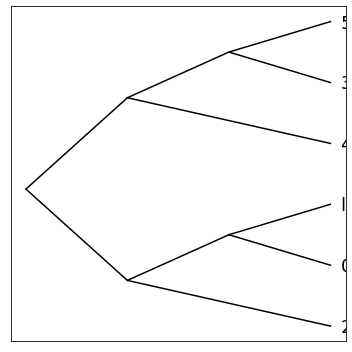

In [64]:
picea.treeplot(tree)